In [1]:
from random import choices, randint, randrange, random, sample
from typing import List, Optional, Callable, Tuple
from collections import namedtuple

import numpy as np

np.random.seed(42)

Genome = List[int]
Population = List[Genome]
PopulateFunc = Callable[[], Population]
FitnessFunc = Callable[[Genome], int]
SelectionFunc = Callable[[Population, FitnessFunc], Tuple[Genome, Genome]]
CrossoverFunc = Callable[[Genome, Genome], Tuple[Genome, Genome]]
MutationFunc = Callable[[Genome], Genome]
PrinterFunc = Callable[[Population, int, FitnessFunc], None]

Station = namedtuple('Station', ['name', 'line_id'])

stations_list = [
    'El Rosario', 'Instituto del Petróleo', 'Deportivo 18 de Marzo', 'La Raza', 'Consulado', 'Martín Carrera',
    'Tacuba', 'Hidalgo', 'Guerrero', 'Garibaldi', 'Bellas Artes', 'Morelos', 'San Lázaro', 'Candelaria',
    'Tacubaya', 'Centro Médico', 'Balderas', 'Salto del Agua', 'Pino Suárez', 'Merced', 'Jamaica', 'Mixcoac',
    'Zapata', 'Ermita', 'General Anaya', 'Tasqueña', 'Universidad'
]

# Create a fully connected metro map with random travel times between 1 and 10 minutes (saves time and helps with the optimization of the program, yk)
metro_map = {}
for start in stations_list:
    for end in stations_list:
        if start != end:  # Avoid self-loops
            if (start, end) not in metro_map and (end, start) not in metro_map:  # Check if connection already exists
                travel_time = randint(1, 10)  
                metro_map[(start, end)] = travel_time
                metro_map[(end, start)] = travel_time  # Ensure undirected connection

print("\nMetro Map Connections:")
for (start, end), time in metro_map.items():
    print(f"From {start} to {end}: {time} minutes")




Metro Map Connections:
From El Rosario to Instituto del Petróleo: 2 minutes
From Instituto del Petróleo to El Rosario: 2 minutes
From El Rosario to Deportivo 18 de Marzo: 5 minutes
From Deportivo 18 de Marzo to El Rosario: 5 minutes
From El Rosario to La Raza: 9 minutes
From La Raza to El Rosario: 9 minutes
From El Rosario to Consulado: 2 minutes
From Consulado to El Rosario: 2 minutes
From El Rosario to Martín Carrera: 8 minutes
From Martín Carrera to El Rosario: 8 minutes
From El Rosario to Tacuba: 6 minutes
From Tacuba to El Rosario: 6 minutes
From El Rosario to Hidalgo: 3 minutes
From Hidalgo to El Rosario: 3 minutes
From El Rosario to Guerrero: 1 minutes
From Guerrero to El Rosario: 1 minutes
From El Rosario to Garibaldi: 1 minutes
From Garibaldi to El Rosario: 1 minutes
From El Rosario to Bellas Artes: 9 minutes
From Bellas Artes to El Rosario: 9 minutes
From El Rosario to Morelos: 4 minutes
From Morelos to El Rosario: 4 minutes
From El Rosario to San Lázaro: 6 minutes
From San 

In [2]:
def create_initial_population(size, start, end, stations_list):
    population = []
    for _ in range(size):
        # Create a path 
        middle_stations = [station for station in stations_list if station not in {start, end}]
        # Generate a random sample of the middle stations and create a complete path
        random_path = [start] + sample(middle_stations, len(middle_stations)) + [end]
        population.append(random_path)
    return population


In [3]:
def calculate_fitness(path, metro_map):
    total_time = 0
    for i in range(len(path) - 1):
        total_time += metro_map.get((path[i], path[i+1]), float('inf'))
    return total_time

def select_parents(population, fitness_func):
    # Tournament selection
    tournament_size = 5
    selected_parents = []
    for _ in range(2):  # Select two parents
        tournament = sample(population, tournament_size)
        tournament.sort(key=fitness_func)
        selected_parents.append(tournament[0])  # Select the best from the tournament
    return selected_parents[0], selected_parents[1]



In [4]:
def crossover(parent_a, parent_b):
    # One-point crossover
    cross_point = randint(1, len(parent_a) - 2)
    child_a = parent_a[:cross_point] + parent_b[cross_point:]
    child_b = parent_b[:cross_point] + parent_a[cross_point:]
    return child_a, child_b

from random import random, choice

def mutate(path, mutation_rate, stations_list, metro_map):
    for i in range(1, len(path) - 1):  # Do not mutate the first and last position
        if random() < mutation_rate:
            # Find all possible stations we can travel to from the previous station
            possible_stations = [e for (s, e) in metro_map if s == path[i-1] and e not in path]
            # If there are no possible stations (which shouldn't normally happen), skip
            if not possible_stations:
                continue
            # Replace the current station with one of the possible options
            path[i] = choice(possible_stations)
    return path



In [5]:

def genetic_algorithm(metro_map, stations_list, start, end, population_size, generations, mutation_rate):
    population = create_initial_population(population_size, start, end, stations_list)
    for generation in range(generations):
        # Calculate fitness for each individual
        fitness_scores = [calculate_fitness(genome, metro_map) for genome in population]
        # Sort the population by fitness (ascending - lower is better)
        population.sort(key=lambda genome: calculate_fitness(genome, metro_map))
        # Check if we found a solution
        if fitness_scores[0] <= mutation_rate:
            break
        # Select parents and create next generation
        new_population = []
        while len(new_population) < population_size:
            parent_a, parent_b = select_parents(population, lambda genome: calculate_fitness(genome, metro_map))
            child_a, child_b = crossover(parent_a, parent_b)
            # Check if the children are valid paths before mutating
            if is_valid_path(child_a, metro_map) and is_valid_path(child_b, metro_map):
                # Mutate children and add to new population
                new_population.append(mutate(child_a, mutation_rate, stations_list, metro_map))
                if len(new_population) < population_size:
                    new_population.append(mutate(child_b, mutation_rate, stations_list, metro_map))
        population = new_population
    return population[0]  # Return the best path found


In [6]:
population_size = 100
generations = 1000
mutation_rate = 0.01

# Define the is_valid_path function
def is_valid_path(path, metro_map):
    for i in range(len(path) - 1):
        if (path[i], path[i+1]) not in metro_map and (path[i+1], path[i]) not in metro_map:
            return False
    return True

# Run the genetic algorithm
best_route = genetic_algorithm(metro_map, stations_list, "El Rosario", "San Lázaro", population_size, generations, mutation_rate)
best_route_time = calculate_fitness(best_route, metro_map)

print("Best route found:", best_route)
print("Total travel time:", best_route_time, "minutes")

Best route found: ['El Rosario', 'Hidalgo', 'Zapata', 'Guerrero', 'Balderas', 'Universidad', 'La Raza', 'Deportivo 18 de Marzo', 'Instituto del Petróleo', 'Mixcoac', 'Bellas Artes', 'Jamaica', 'La Raza', 'Candelaria', 'Consulado', 'Guerrero', 'Pino Suárez', 'Ermita', 'Garibaldi', 'General Anaya', 'Salto del Agua', 'Ermita', 'General Anaya', 'Salto del Agua', 'Martín Carrera', 'Zapata', 'San Lázaro']
Total travel time: 41 minutes


# Some extra

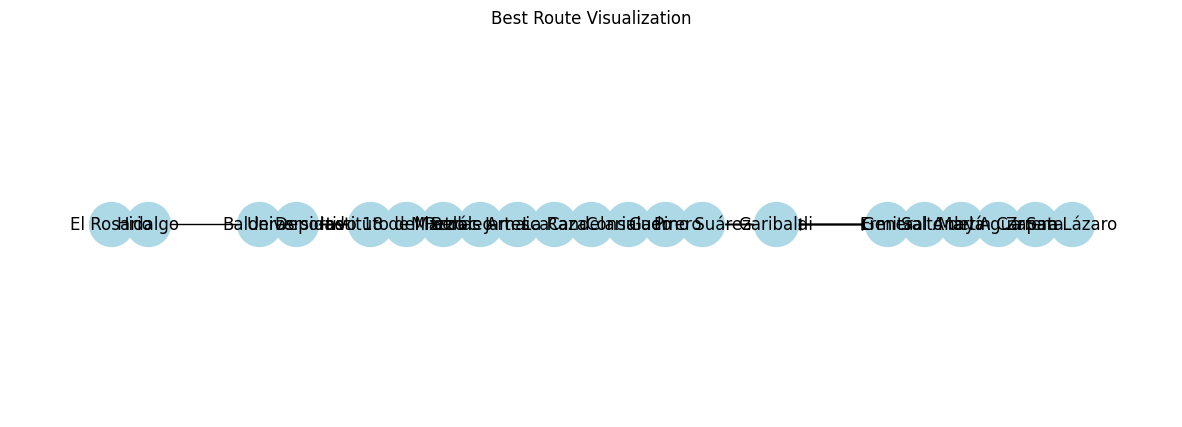

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_route(route, stations_list):
    # Create a directed graph
    G = nx.DiGraph()
    

    pos = {station: (i, 0) for i, station in enumerate(route)}
    
    G.add_nodes_from(route)
    edges = list(zip(route[:-1], route[1:]))  # Create edge pairs
    G.add_edges_from(edges)

    plt.figure(figsize=(15, 5))

    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000)
    nx.draw_networkx_edges(G, pos, arrowsize=20)
    nx.draw_networkx_labels(G, pos, font_size=12)
    plt.title('Best Route Visualization')
    plt.axis('off')  


    plt.show()
plot_route(best_route, stations_list)



In [11]:
import tkinter as tk
from tkinter import ttk


def run_algorithm():
    start = start_station_var.get()
    end = end_station_var.get()
    pop_size = int(population_size_var.get())
    gen_count = int(generations_var.get())
    mut_rate = float(mutation_rate_var.get())
    
    # Run the genetic algorithm
    best_route = genetic_algorithm(metro_map, stations_list, start, end, pop_size, gen_count, mut_rate)
    
    # Display the best route in the text widget
    result_display.config(state=tk.NORMAL)
    result_display.delete(1.0, tk.END)
    result_display.insert(tk.END, f"Best route from {start} to {end}:\n{best_route}")
    result_display.config(state=tk.DISABLED)

# Setup the main window
root = tk.Tk()
root.title("Genetic Algorithm for Route Optimization")

# Setup entry widgets for user inputs
start_station_var = tk.StringVar(value='El Rosario')
end_station_var = tk.StringVar(value='San Lázaro')
population_size_var = tk.StringVar(value='100')
generations_var = tk.StringVar(value='1000')
mutation_rate_var = tk.StringVar(value='0.01')

ttk.Label(root, text="Start Station:").pack(fill='x', padx=5, pady=5)
start_station_entry = ttk.Entry(root, textvariable=start_station_var)
start_station_entry.pack(fill='x', padx=5, pady=5)

ttk.Label(root, text="End Station:").pack(fill='x', padx=5, pady=5)
end_station_entry = ttk.Entry(root, textvariable=end_station_var)
end_station_entry.pack(fill='x', padx=5, pady=5)

ttk.Label(root, text="Population Size:").pack(fill='x', padx=5, pady=5)
population_size_entry = ttk.Entry(root, textvariable=population_size_var)
population_size_entry.pack(fill='x', padx=5, pady=5)

ttk.Label(root, text="Generations:").pack(fill='x', padx=5, pady=5)
generations_entry = ttk.Entry(root, textvariable=generations_var)
generations_entry.pack(fill='x', padx=5, pady=5)

ttk.Label(root, text="Mutation Rate:").pack(fill='x', padx=5, pady=5)
mutation_rate_entry = ttk.Entry(root, textvariable=mutation_rate_var)
mutation_rate_entry.pack(fill='x', padx=5, pady=5)

# Button to run the genetic algorithm
run_button = ttk.Button(root, text="Find Best Route", command=run_algorithm)
run_button.pack(fill='x', padx=5, pady=5)

# Text widget to display results
result_display = tk.Text(root, height=10)
result_display.config(state=tk.DISABLED)  # Disable editing of the text widget
result_display.pack(fill='both', expand=True, padx=5, pady=5)

# Start the GUI event loop
root.mainloop()
